In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Logistik Regression Modell

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words('english'))
additional_stopwords = {"al", "god", "https", "ahly", "http"}
stop_words = stop_words.union(additional_stopwords)

def custom_preprocess(text):
    text = text.lower()
    text = re.sub(r'\bha\s+ha\b', 'haha', text)
    text = re.sub(r"\b(\w+)'\s*s\b", r"\1's", text)
    return text

def preprocess(tweet):
    tweet = tweet.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', tweet)
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        if lemma not in stop_words:
            processed_words.append(lemma)
    return " ".join(processed_words)

df = pd.read_csv("./assets/combined.csv")
df.dropna(subset=["tweet", "Status"], inplace=True)
df["processed_tweet"] = df["tweet"].apply(preprocess)

X = df["processed_tweet"]
y = df["Status"]

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9537689642814479
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4420
           1       0.94      0.96      0.95      3951

    accuracy                           0.95      8371
   macro avg       0.95      0.95      0.95      8371
weighted avg       0.95      0.95      0.95      8371



In [3]:
# Fake / Real Gewichtung

import pandas as pd

# Hole die Wortvektoren und Gewichte
feature_names = tfidf.get_feature_names_out()
coefficients = clf.coef_[0]

# Erstelle DataFrame mit Wörtern und ihren Koeffizienten
weights = pd.DataFrame({
    "Wort": feature_names,
    "Gewicht": coefficients
})

# Sortiere nach Einfluss
top_fake = weights.sort_values("Gewicht", ascending=False).head(15)
top_real = weights.sort_values("Gewicht", ascending=True).head(15)

# Zeige Ergebnisse
print("Top-Wörter für Klasse 'Fake':")
print(top_fake)

print("\nTop-Wörter für Klasse 'Real':")
print(top_real)


Top-Wörter für Klasse 'Fake':
           Wort    Gewicht
6899       haha  18.592927
6902   hahahaha   5.410101
7508      hilal   4.978119
9580     league   4.902141
14128    riyadh   4.416139
14659       say   4.259966
14799       see   4.187306
9290       know   4.103902
9716       like   4.098301
6571         go   3.987500
17498   verdict   3.881271
10665      mean   3.727198
16393      take   3.499746
13770   referee   3.422034
3727   crescent   3.398195

Top-Wörter für Klasse 'Real':
              Wort    Gewicht
3225            co -12.467038
16572         team  -4.950096
428          ahmed  -4.681493
14231        round  -4.615941
4932      egyptian  -4.432399
7400          held  -4.375675
11073      mohamed  -4.338671
1241   association  -4.017121
4958            el  -4.011328
582     alexandria  -3.933223
10557        match  -3.910311
16966     training  -3.831696
16581    technical  -3.445490
10534        masry  -3.421306
10108      mahmoud  -3.315043


<Figure size 1000x500 with 0 Axes>

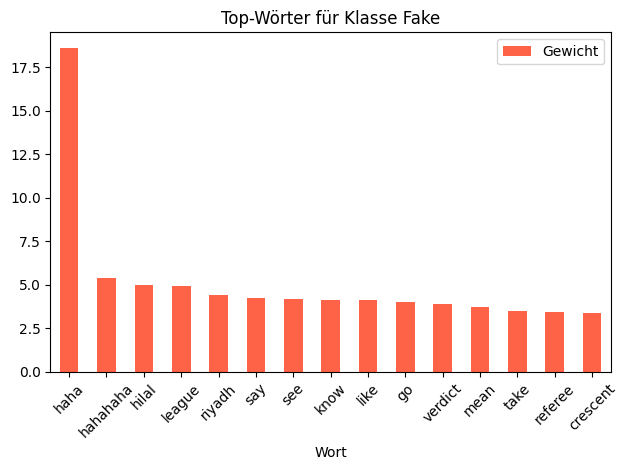

<Figure size 1000x500 with 0 Axes>

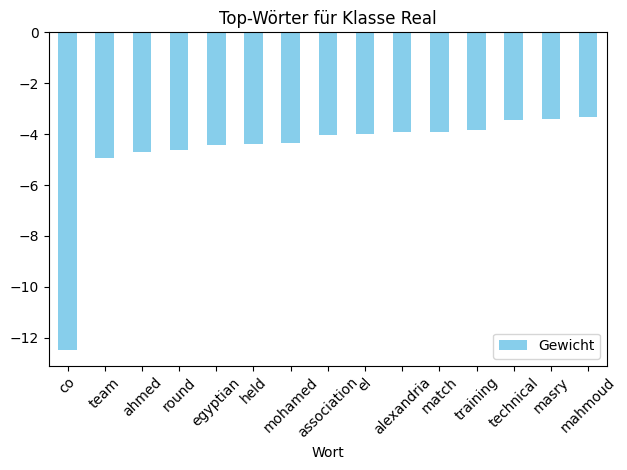

In [4]:
# Fake / Real Plot

import matplotlib.pyplot as plt

# Top 15 Fake-Wörter
plt.figure(figsize=(10, 5))
top_fake.plot(kind='bar', x='Wort', y='Gewicht', color='tomato', title='Top-Wörter für Klasse Fake')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 15 Real-Wörter
plt.figure(figsize=(10, 5))
top_real.plot(kind='bar', x='Wort', y='Gewicht', color='skyblue', title='Top-Wörter für Klasse Real')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
